In [3]:
#Importing Packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


In [4]:
# Defining model architecture
class AllConvNet(pl.LightningModule):
    def __init__(self, num_classes_cifar):
        super().__init__()

        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Pooling layers
        self.pool = nn.MaxPool2d(2, stride=2)

        # Output convolutional layer
        self.conv4 = nn.Conv2d(128, num_classes_cifar, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)

        # Final convolutional layer with kernel size equal to the size of the feature map
        x = F.relu(self.conv4(x))

        # Global average pooling
        x = F.avg_pool2d(x, x.shape[2:])

        return x.view(x.size(0), -1)

    def training_step(self, batch, batch_idx):
      x, y = batch
      y_hat = self(x)
      loss = F.cross_entropy(y_hat, y)
      self.log("train_loss", loss)

      # Calculate accuracy
      pred_labels = torch.argmax(y_hat, dim=1)
      accuracy = torchmetrics.functional.accuracy(pred_labels, y, task="multiclass", num_classes= len(set(y)))
      self.log("train_accuracy", accuracy, on_step=False, on_epoch=True)

      return loss

    # validation_step method
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        pred_labels = torch.argmax(y_hat, dim=1)
        accuracy = torchmetrics.functional.accuracy(pred_labels, y, task="multiclass", num_classes= len(set(y)))
        self.log("val_loss", loss)
        self.log("val_accuracy", accuracy, on_step=False, on_epoch=True)

    # test_step method
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        pred_labels = torch.argmax(y_hat, dim=1)
        accuracy = torchmetrics.functional.accuracy(pred_labels, y, task="multiclass", num_classes= len(set(y)))
        self.log("test_loss", loss)
        self.log("test_accuracy", accuracy, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer



In [5]:
# Data Preperation

train_transforms_reg_data_aug = transforms.Compose([
    transforms.RandomResizedCrop(64),  # Change crop size to 64x64
    transforms.RandomHorizontalFlip(),  # Flip horizontally randomly
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),  # Adjust color brightness, contrast, saturation, and hue
    transforms.RandomRotation(15),  # Rotate randomly up to 15 degrees
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.4912, 0.4821, 0.4455), (0.2370, 0.2437, 0.2626)),  # Normalize image tensor
])
test_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4921, 0.4832, 0.4488), (0.2570, 0.2235, 0.2676)),
])

# Load CIFAR10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transforms_reg_data_aug)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transforms)
num_classes_cifar = len(train_dataset.classes)


# Define your training and validation data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)




100%|██████████| 170498071/170498071 [00:01<00:00, 100904678.70it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
# Training from Scratch
# Define model and optimizer
model = AllConvNet(num_classes_cifar)
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training from scratch on CIFAR10
# Define LightningModule for training from scratch
class TrainFromScratch(pl.LightningModule):
    def __init__(self, model, criterion, optimizer):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        self.log('train_loss', loss)
        # Calculate accuracy
        preds = torch.argmax(outputs, dim=1)
        acc = self.accuracy(preds, targets)
        self.log('train_accuracy', acc, on_step=False, on_epoch=True)
        return loss
    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        self.log('test_loss', loss)
        # Calculate accuracy
        preds = torch.argmax(outputs, dim=1)
        acc = self.accuracy(preds, targets)
        self.log('test_accuracy', acc, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return self.optimizer

# Initialize training from scratch LightningModule
scratch_model = TrainFromScratch(model, nn.CrossEntropyLoss(), optimizer)

# Train from scratch
trainer_scratch = pl.Trainer(max_epochs=10)
trainer_scratch.fit(scratch_model, train_loader, val_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | AllConvNet         | 104 K 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
104 K     Trainable params
0         Non-trainable params
104 K     Total params
0.419   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [8]:
torch.save(scratch_model.state_dict(), 'AllConvNet_Model_Reg_tf.pth')

In [10]:
#Evaluation
Train_metrics_Scratch = trainer_scratch.logged_metrics
trainer_scratch.test(scratch_model, test_loader)
Test_metrics_Scratch = trainer_scratch.logged_metrics
train_loss = {key: value for key, value in Train_metrics_Scratch.items() if key == 'train_loss'}
print(train_loss)
print(Test_metrics_Scratch)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.07119999825954437    │
│         test_loss         │    2.3030481338500977     │
└───────────────────────────┴───────────────────────────┘

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'train_loss': tensor(2.1176)}
{'test_loss': tensor(2.3030), 'test_accuracy': tensor(0.0712)}


In [11]:
# Fine-tune with pretrained weights
# Load pretrained weights
pretrained_model = AllConvNet(num_classes_cifar)
pretrained_model.load_state_dict(torch.load('Regularization_Model_data_aug.pth'))

# Modify the last layer for CIFAR10
pretrained_model.fc = nn.Conv2d(192, 10, kernel_size=1)

# Define LightningModule for fine-tuning
class FineTune(pl.LightningModule):
    def __init__(self, model, criterion, optimizer, train_loader):  # Add train_loader as an argument
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader  # Store train_loader
        self.train_losses = []  # List to store training losses

        # Initialize accuracy metric
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes_cifar)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        self.log('train_loss', loss)
        self.train_losses.append(loss.item())  # Append the loss value to the list
        # Calculate accuracy
        preds = torch.argmax(outputs, dim=1)
        acc = self.accuracy(preds, targets)
        self.log('train_accuracy', acc, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.accuracy(y_hat, y)
        self.log("val_accuracy", self.accuracy)
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        self.log('test_loss', loss)

        # Calculate accuracy
        preds = torch.argmax(outputs, dim=1)
        acc = self.accuracy(preds, targets)
        self.log('test_accuracy', acc, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return self.optimizer

optimizer_pretrained = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)

# Initialize fine-tuning LightningModule
fine_tune_model = FineTune(pretrained_model, nn.CrossEntropyLoss(), optimizer_pretrained, train_loader)


# Initialize fine-tuning LightningModule
fine_tune_model = FineTune(pretrained_model, nn.CrossEntropyLoss(), optimizer_pretrained,train_loader)

# Fine-tune the model
trainer_fine_tune = pl.Trainer(max_epochs=50)
trainer_fine_tune.fit(fine_tune_model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | AllConvNet         | 106 K 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
106 K     Trainable params
0         Non-trainable params
106 K     Total params
0.427     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


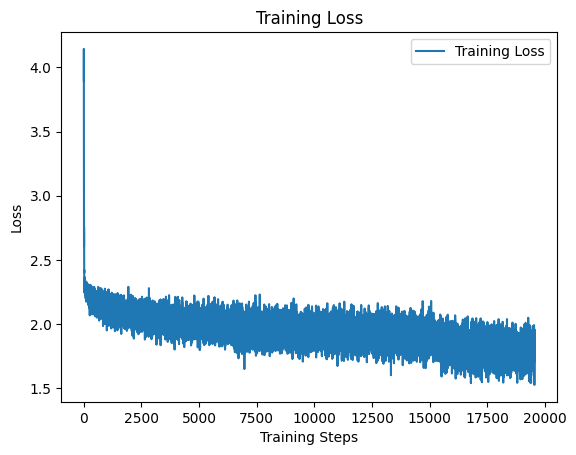

In [12]:
# Plot loss with epochs
plt.plot(range(1, len(fine_tune_model.train_losses) + 1), fine_tune_model.train_losses, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [13]:
# Evaluate Transfer Learning Model
Train_metrics_FineTune = trainer_fine_tune.logged_metrics
trainer_fine_tune.test(fine_tune_model, test_loader)
Test_metrics_FineTune = trainer_fine_tune.logged_metrics
print(Train_metrics_FineTune)
print(Test_metrics_FineTune)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'train_loss': tensor(2.1176)}
{'test_loss': tensor(2.3030), 'test_accuracy': tensor(0.0712)}


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.10300000011920929    │
│         test_loss         │     2.392636775970459     │
└───────────────────────────┴───────────────────────────┘

{'train_loss': tensor(1.9016), 'val_accuracy': tensor(0.1030), 'val_loss': tensor(2.3926)}
{'test_loss': tensor(2.3926), 'test_accuracy': tensor(0.1030)}


In [16]:
# Evaluate Trained from Scratch Model
print("Model Trained from Scratch")
print(Train_metrics_Scratch)
print(Test_metrics_Scratch)
print("#############################################")
print("Model Fine Tuned")
print(Train_metrics_FineTune)
print(Test_metrics_FineTune)

Model Trained from Scratch
{'train_loss': tensor(2.1176), 'train_accuracy': tensor(0.1359)}
{'test_loss': tensor(2.3030), 'test_accuracy': tensor(0.0712)}
#############################################
Model Fine Tuned
{'train_loss': tensor(1.9016),  'train_accuracy': tensor(0.1409), 'val_accuracy': tensor(0.1030), 'val_loss': tensor(2.3926)}
{'test_loss': tensor(2.3926), 'test_accuracy': tensor(0.1030)}


In [ ]:
torch.save(fine_tune_model.state_dict(), 'transferlearning_finetunemodel.pth')